In [13]:
import pandas as pd

# Load the CSV file
file_path = 'TQQQ-15second-2024-08.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
data.head(), data.columns


(                   timestamp   open   high    low  close  volume     vwap
 0  2024-08-01 04:00:00-04:00  69.58  70.00  69.50  69.53    5492  69.6862
 1  2024-08-01 04:00:15-04:00  69.48  69.55  69.48  69.54    1099  69.5325
 2  2024-08-01 04:00:30-04:00  69.60  69.62  69.55  69.55    5276  69.5578
 3  2024-08-01 04:00:45-04:00  69.53  69.54  69.50  69.50    3699  69.5135
 4  2024-08-01 04:01:00-04:00  69.52  69.53  69.44  69.45    7907  69.4827,
 Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap'], dtype='object'))

In [14]:
import pandas as pd

# Custom function to calculate EMA
def ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

# Custom function to calculate RSI
def rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Custom function to calculate MACD
def macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = ema(series, fastperiod)
    ema_slow = ema(series, slowperiod)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signalperiod)
    return macd_line, signal_line

# Load the CSV file
data = pd.read_csv('TQQQ-15second-2024-08.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')

# Calculate RSI, EMA Fast, EMA Slow, and MACD
data['RSI'] = rsi(data['close'], period=14)
data['EMA_Fast'] = ema(data['close'], period=3)
data['EMA_Slow'] = ema(data['close'], period=9)
data['MACD'], data['MACD_Signal'] = macd(data['close'])

# Calculate envelope
envelope_length = 21
envelope_percent = 0.3 / 100
data['Envelope_Upper'] = ema(data['close'], period=envelope_length) * (1 + envelope_percent)
data['Envelope_Lower'] = ema(data['close'], period=envelope_length) * (1 - envelope_percent)

# Initialize columns for scores
data['score_ema'] = 0
data['score_macd'] = 0
data['score_rsi30'] = 0
data['score_envelope'] = 0
data['score_bullCond'] = 0

data['sell_score_ema'] = 0
data['sell_score_macd'] = 0
data['sell_score_rsi70'] = 0
data['sell_score_envelope'] = 0
data['sell_score_bearCond'] = 0

# Variables to track scores
max_buy_score = 700
max_sell_score = 600

# Calculate scores for each row
for i in range(1, len(data)):
    # Buy conditions
    if data['EMA_Fast'].iloc[i] > data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'score_ema'] = 100
    else:
        data.at[i, 'score_ema'] = max(0, data.at[i-1, 'score_ema'] - 10)
    
    if data['MACD'].iloc[i] > data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] < 0 and data['MACD'].iloc[i-1] <= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'score_macd'] = 100
    else:
        data.at[i, 'score_macd'] = max(0, data.at[i-1, 'score_macd'] - 10)
    
    if data['RSI'].iloc[i] > 30 and data['RSI'].iloc[i-1] <= 30:
        data.at[i, 'score_rsi30'] = 100
    else:
        data.at[i, 'score_rsi30'] = max(0, data.at[i-1, 'score_rsi30'] - 10)
    
    if data['EMA_Fast'].iloc[i] > data['Envelope_Lower'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['Envelope_Lower'].iloc[i-1]:
        data.at[i, 'score_envelope'] = 100
    else:
        data.at[i, 'score_envelope'] = max(0, data.at[i-1, 'score_envelope'] - 10)

    # Sell conditions
    if data['EMA_Fast'].iloc[i] < data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'sell_score_ema'] = 100
    else:
        data.at[i, 'sell_score_ema'] = max(0, data.at[i-1, 'sell_score_ema'] - 10)
    
    if data['MACD'].iloc[i] < data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] > 0 and data['MACD'].iloc[i-1] >= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'sell_score_macd'] = 100
    else:
        data.at[i, 'sell_score_macd'] = max(0, data.at[i-1, 'sell_score_macd'] - 10)
    
    if data['RSI'].iloc[i] < 70 and data['RSI'].iloc[i-1] >= 70:
        data.at[i, 'sell_score_rsi70'] = 100
    else:
        data.at[i, 'sell_score_rsi70'] = max(0, data.at[i-1, 'sell_score_rsi70'] - 10)
    
    if data['EMA_Fast'].iloc[i] < data['Envelope_Upper'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['Envelope_Upper'].iloc[i-1]:
        data.at[i, 'sell_score_envelope'] = 100
    else:
        data.at[i, 'sell_score_envelope'] = max(0, data.at[i-1, 'sell_score_envelope'] - 10)

# Calculate total scores and percentages
data['score'] = data['score_ema'] + data['score_macd'] + data['score_rsi30'] + data['score_envelope'] + data['score_bullCond']
data['sell_score'] = data['sell_score_ema'] + data['sell_score_macd'] + data['sell_score_rsi70'] + data['sell_score_envelope'] + data['sell_score_bearCond']

data['total_percent'] = (data['score'] / max_buy_score) * 100
data['total_sell_percent'] = (data['sell_score'] / max_sell_score) * 100

# Display relevant columns for buy/sell signals
print(data[['timestamp', 'score', 'sell_score', 'total_percent', 'total_sell_percent']].tail())


                     timestamp  score  sell_score  total_percent  \
3471 2024-08-01 19:58:45-04:00      0         100            0.0   
3472 2024-08-01 19:59:00-04:00      0         190            0.0   
3473 2024-08-01 19:59:15-04:00      0         270            0.0   
3474 2024-08-01 19:59:30-04:00      0         240            0.0   
3475 2024-08-01 19:59:45-04:00      0         210            0.0   

      total_sell_percent  
3471           16.666667  
3472           31.666667  
3473           45.000000  
3474           40.000000  
3475           35.000000  


In [15]:
# Implementing custom EMA calculation
def ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

# Implementing custom RSI calculation
def rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Calculating RSI, EMA Fast and Slow
data['RSI'] = rsi(data['close'], period=14)
data['EMA_Fast'] = ema(data['close'], period=3)
data['EMA_Slow'] = ema(data['close'], period=9)

# Implementing custom MACD calculation
def macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = ema(series, fastperiod)
    ema_slow = ema(series, slowperiod)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signalperiod)
    return macd_line, signal_line

data['MACD'], data['MACD_Signal'] = macd(data['close'])

# Calculate envelope
envelope_length = 21
envelope_percent = 0.3 / 100
data['Envelope_Upper'] = ema(data['close'], period=envelope_length) * (1 + envelope_percent)
data['Envelope_Lower'] = ema(data['close'], period=envelope_length) * (1 - envelope_percent)

# Displaying the calculated columns
data[['timestamp', 'RSI', 'EMA_Fast', 'EMA_Slow', 'MACD', 'MACD_Signal', 'Envelope_Upper', 'Envelope_Lower']].head()


,timestamp,RSI,EMA_Fast,EMA_Slow,MACD,MACD_Signal,Envelope_Upper,Envelope_Lower
0,2024-08-01 04:00:00-04:00,NaN,69.530000,69.530000,0.000000,0.000000,69.738590,69.321410
1,2024-08-01 04:00:15-04:00,100.000000,69.535000,69.532000,0.000798,0.000160,69.739502,69.322316
2,2024-08-01 04:00:30-04:00,100.000000,69.542500,69.535600,0.002211,0.000570,69.741243,69.324047
3,2024-08-01 04:00:45-04:00,28.571429,69.521250,69.528480,-0.000695,0.000317,69.738266,69.321088
4,2024-08-01 04:01:00-04:00,16.666667,69.485625,69.512784,-0.006953,-0.001137,69.731001,69.313866


In [23]:
# Initialize columns for scores
data['score_ema'] = 0
data['score_macd'] = 0
data['score_rsi30'] = 0
data['score_envelope'] = 0
data['score_bullishEng'] = 0
data['score_bullCond'] = 0

data['sell_score_ema'] = 0
data['sell_score_macd'] = 0
data['sell_score_rsi70'] = 0
data['sell_score_envelope'] = 0
data['sell_score_bearCond'] = 0

# Variables to track scores
max_buy_score = 700
max_sell_score = 600

# Define the conditions and score calculations for each row
for i in range(1, len(data)):
    # Buy conditions
    if data['EMA_Fast'].iloc[i] > data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'score_ema'] = 100
    else:
        data.at[i, 'score_ema'] = max(0, data.at[i-1, 'score_ema'] - 10)
    
    if data['MACD'].iloc[i] > data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] < 0 and data['MACD'].iloc[i-1] <= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'score_macd'] = 100
    else:
        data.at[i, 'score_macd'] = max(0, data.at[i-1, 'score_macd'] - 10)
    
    if data['RSI'].iloc[i] > 30 and data['RSI'].iloc[i-1] <= 30:
        data.at[i, 'score_rsi30'] = 100
    else:
        data.at[i, 'score_rsi30'] = max(0, data.at[i-1, 'score_rsi30'] - 10)
    
    if data['EMA_Fast'].iloc[i] > data['Envelope_Lower'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['Envelope_Lower'].iloc[i-1]:
        data.at[i, 'score_envelope'] = 100
    else:
        data.at[i, 'score_envelope'] = max(0, data.at[i-1, 'score_envelope'] - 10)

    # Sell conditions
    if data['EMA_Fast'].iloc[i] < data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'sell_score_ema'] = 100
    else:
        data.at[i, 'sell_score_ema'] = max(0, data.at[i-1, 'sell_score_ema'] - 10)
    
    if data['MACD'].iloc[i] < data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] > 0 and data['MACD'].iloc[i-1] >= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'sell_score_macd'] = 100
    else:
        data.at[i, 'sell_score_macd'] = max(0, data.at[i-1, 'sell_score_macd'] - 10)
    
    if data['RSI'].iloc[i] < 70 and data['RSI'].iloc[i-1] >= 70:
        data.at[i, 'sell_score_rsi70'] = 100
    else:
        data.at[i, 'sell_score_rsi70'] = max(0, data.at[i-1, 'sell_score_rsi70'] - 10)
    
    if data['EMA_Fast'].iloc[i] < data['Envelope_Upper'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['Envelope_Upper'].iloc[i-1]:
        data.at[i, 'sell_score_envelope'] = 100
    else:
        data.at[i, 'sell_score_envelope'] = max(0, data.at[i-1, 'sell_score_envelope'] - 10)

# Calculate total scores and percentages
data['score'] = data['score_ema'] + data['score_macd'] + data['score_rsi30'] + data['score_envelope'] + data['score_bullCond']
data['sell_score'] = data['sell_score_ema'] + data['sell_score_macd'] + data['sell_score_rsi70'] + data['sell_score_envelope'] + data['sell_score_bearCond']

data['total_percent'] = (data['score'] / max_buy_score) * 100
data['total_sell_percent'] = (data['sell_score'] / max_sell_score) * 100

# Display relevant columns for buy/sell signals
data[['timestamp', 'score', 'sell_score', 'total_percent', 'total_sell_percent']].tail(100)




KeyError: 0

c:\Users\TGAdmin\.conda\envs\tgEnv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


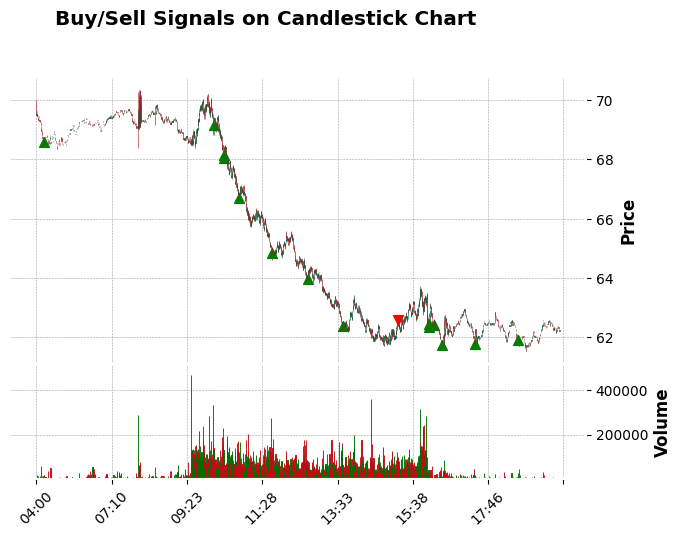

In [18]:
import mplfinance as mpf

# เตรียมข้อมูลสำหรับการ plot
data['Date'] = pd.to_datetime(data['timestamp'])
data.set_index('Date', inplace=True)

# เลือกคอลัมน์ที่ใช้สำหรับการ plot
plot_data = data[['open', 'high', 'low', 'close', 'volume']]

# กำหนดจุดที่เป็นสัญญาณซื้อและขาย
buy_signals = data[data['total_percent'] > 50]
sell_signals = data[data['total_sell_percent'] > 60]

# สร้าง DataFrame ใหม่สำหรับสัญญาณซื้อและขาย
buy_marker_data = pd.DataFrame(index=plot_data.index)
sell_marker_data = pd.DataFrame(index=plot_data.index)

# ใส่ค่า low และ high ตามลำดับสำหรับสัญญาณซื้อและขาย
buy_marker_data['Buy'] = buy_signals['low'] - 0.1
sell_marker_data['Sell'] = sell_signals['high'] + 0.1

# เตรียมการ plot จุดซื้อขายบนกราฟ
buy_markers = mpf.make_addplot(buy_marker_data['Buy'], type='scatter', markersize=50, marker='^', color='green')
sell_markers = mpf.make_addplot(sell_marker_data['Sell'], type='scatter', markersize=50, marker='v', color='red')

# Plot กราฟแท่งเทียนพร้อมสัญญาณ
mpf.plot(plot_data, type='candle', style='charles', addplot=[buy_markers, sell_markers], volume=True, title='Buy/Sell Signals on Candlestick Chart', ylabel='Price', ylabel_lower='Volume')
